# **Извлекаем эмбеддинги из семантического парсера**

**BERT (и другие модели из библиотеки Hugging Face) состоит из двух частей:**

**Base Model (основа):** Это часть модели, которая генерирует эмбеддинги (векторные представления) для входных токенов.

**Head (голова):** Это дополнительный слой, который используется для конкретной задачи (например, классификация, NER, маскирование токенов и т.д.).

In [ ]:
# Я взяла за основу тетратку с NER, поменяла немного архитектуру модели и поменяла задачу с NER на предсказание семантических классов

In [ ]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, TrainingArguments, Trainer

# AutoModelForTokenClassification загружает BERT с головой для задачи классификации токенов (Token Classification), вместо него использую просто AutoModel

import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import torch
import evaluate
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import csv

In [ ]:
import evaluate # эту ячейку не запускала, она предназначена для NER
! pip install seqeval
metric = evaluate.load('seqeval')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=2e77905548a1ca891a4f6d2d85de9c46708c57fd74db9432e4061bcf0d8daa31
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
!pip install tabulate # эта ячейка тоже быссмыслена
from tabulate import tabulate

In [ ]:
import seaborn as sns
from collections import Counter
import numpy as np

In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd

# **Попытка 3**

**Функция для распарсивания датасета**

In [ ]:
# Парсинг  (взяла из кода Насти и переработала для своих данных), т.к лень переводить файлы из conllu в csv
train, val, test = [], [], [] # списки для хранения тренировачных, валидационных и тестовых данных

for filepath, data in [('/content/train.conllu', train), # те самые три файла
                       ('/content/val.conllu', val),
                       ('/content/test.conllu', test)]:
    with open(filepath, encoding='utf8') as file:
        current_sent = []
        for line in file:
            if line[0].isdigit():
                token = line.strip().split('\t')
                form, semclass = token[1], token[-1] # мне нужна колонка form и semclass
                current_sent.append((form, semclass))
            elif current_sent:
                data.append(current_sent)
                current_sent = []
        if current_sent:
            data.append(current_sent)

In [ ]:
# проверяю на правильность обработки (1 предложение)
print(f"Train: {len(train)} предложений, пример:", train[0])
print(f"Val: {len(val)} предложений, пример:", val[0])
print(f"Test: {len(test)} предложений, пример:", test[0])

Train: 27520 предложений, пример: [('Среди', 'PREPOSITION'), ('них', 'ENTITY_OR_SITUATION_PRONOUN'), ('#NULL', 'EXISTENCE_AND_POSSESSION'), ('-', '_'), ('статуя', 'FINE_ARTS_OBJECTS'), ('Христа', 'BEING'), ('-', '_'), ('Спасителя', 'BEING'), ('и', 'COORDINATING_CONJUNCTIONS'), ('гора', 'SURFACE_AND_ITS_SPECIALITIES'), ('Сахарная', 'FOOD'), ('голова', 'PART_OF_ORGANISM'), ('в', 'PREPOSITION'), ('Рио-де- Жанейро', 'ADMINISTRATIVE_REGION'), (',', '_'), ('площадь', 'URBAN_SPACE_AND_ROADS'), ('Согласия', 'CH_OF_CONNECTIONS'), ('в', 'PREPOSITION'), ('Париже', 'INHABITED_LOCALITY'), (',', '_'), ('Бранденбургские', 'INHABITED_LOCALITY'), ('ворота', 'PART_OF_CONSTRUCTION'), ('в', 'PREPOSITION'), ('Берлине', 'INHABITED_LOCALITY'), ('.', '_')]
Val: 6881 предложений, пример: [('На', 'PREPOSITION'), ('его', 'BEING'), ('безопасность', 'RISK_DANGER'), ('произошедшее', 'TO_TAKE_PLACE'), ('#NULL', 'ENTITY_OR_SITUATION_PRONOUN'), ('никак', 'CH_REFERENCE_AND_QUANTIFICATION'), ('не', 'PARTICLES'), ('повли

**Распределение семантических меток**

In [ ]:
# так как там всего семантических классов 455, я все думала, как их правильно вывести красиво, как вы уже поняли, не придумала, как вывести все, поэтому вывела топ 10 популярных

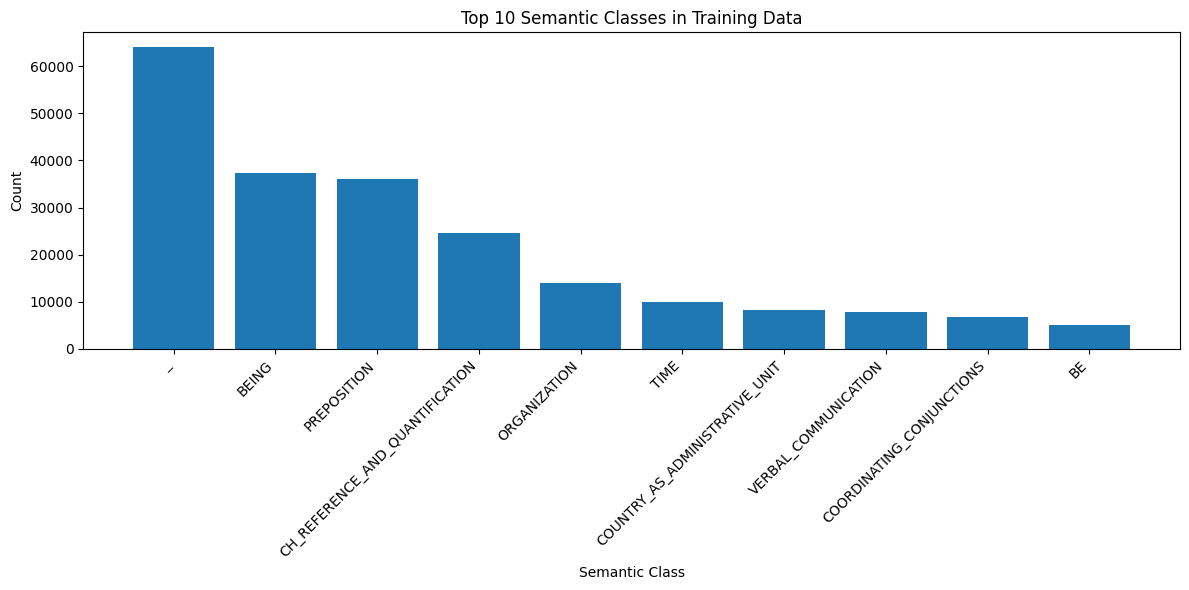

Top 10 классов с частотами:
[('_', 63984), ('BEING', 37260), ('PREPOSITION', 36115), ('CH_REFERENCE_AND_QUANTIFICATION', 24515), ('ORGANIZATION', 13965), ('TIME', 9936), ('COUNTRY_AS_ADMINISTRATIVE_UNIT', 8272), ('VERBAL_COMMUNICATION', 7735), ('COORDINATING_CONJUNCTIONS', 6745), ('BE', 4997)]


In [ ]:
# смотрела топ 10 самых популярных семантических классов в тренировачной выборке
from collections import Counter
def plot_top_semclasses(semclass_labels, top_n=10):
    all_semclasses = [label for sentence in semclass_labels for label in sentence]
    semclass_counts = Counter(all_semclasses)
    top_classes = semclass_counts.most_common(top_n)
    labels, counts = zip(*top_classes)

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts)
    plt.title(f'Top {top_n} Semantic Classes in Training Data')
    plt.xlabel('Semantic Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
# смотрела только для тренировачной части
plot_top_semclasses(train_data)

all_classes = [label for sentence in train_data for label in sentence]
print("Top 10 классов с частотами:")
print(Counter(all_classes).most_common(10))

In [ ]:
# Затем разделяю предложения на метки
# (для тренировочного датасета)
train_sentences = [[form for (form, _) in sent] for sent in train]
train_labels = [[label for (_, label) in sent] for sent in train]
# train_sentences - это список предложений, где каждое предложение — это список слов
# train_labels - это список меток, где каждый элемент соответствует метке слова из train_sentences
# ( для валидационного датасета)
val_sentences = [[form for (form, _) in sent] for sent in val]
val_labels = [[label for (_, label) in sent] for sent in val]

# (и для тестового датасета)
test_sentences = [[form for (form, _) in sent] for sent in test]
test_labels = [[label for (_, label) in sent] for sent in test]

In [ ]:
# проверяю
print("Train пример:", train_sentences[0], train_labels[0])
print("Val пример:", val_sentences[0], val_labels[0])
print("Test пример:", test_sentences[0], test_labels[0])

Train пример: ['Среди', 'них', '#NULL', '-', 'статуя', 'Христа', '-', 'Спасителя', 'и', 'гора', 'Сахарная', 'голова', 'в', 'Рио-де- Жанейро', ',', 'площадь', 'Согласия', 'в', 'Париже', ',', 'Бранденбургские', 'ворота', 'в', 'Берлине', '.'] ['PREPOSITION', 'ENTITY_OR_SITUATION_PRONOUN', 'EXISTENCE_AND_POSSESSION', '_', 'FINE_ARTS_OBJECTS', 'BEING', '_', 'BEING', 'COORDINATING_CONJUNCTIONS', 'SURFACE_AND_ITS_SPECIALITIES', 'FOOD', 'PART_OF_ORGANISM', 'PREPOSITION', 'ADMINISTRATIVE_REGION', '_', 'URBAN_SPACE_AND_ROADS', 'CH_OF_CONNECTIONS', 'PREPOSITION', 'INHABITED_LOCALITY', '_', 'INHABITED_LOCALITY', 'PART_OF_CONSTRUCTION', 'PREPOSITION', 'INHABITED_LOCALITY', '_']
Val пример: ['На', 'его', 'безопасность', 'произошедшее', '#NULL', 'никак', 'не', 'повлияло', '.'] ['PREPOSITION', 'BEING', 'RISK_DANGER', 'TO_TAKE_PLACE', 'ENTITY_OR_SITUATION_PRONOUN', 'CH_REFERENCE_AND_QUANTIFICATION', 'PARTICLES', 'CH_POWER_AND_EFFECT', '_']
Test пример: ['В', 'поздравительной', 'телеграмме', ',', 'Путин

In [ ]:
from sklearn.model_selection import train_test_split
# (разделю данные, в этот раз использую tet_size = 0.2)
new_train_sentences, new_val_sentences, new_train_labels, new_val_labels = train_test_split(
    train_sentences,
    train_labels,
    test_size=0.2,  # 20% о train
    random_state=42
)
# new_train: 64%
# new_val: 16% (от исходного train)
# val: 10% (исходный валидационный)
# test: 10%
# то есть я использовала:
# new_train_sentences, new_train_labels - для тренировки
# new_val_sentences, new_val_labels - для валидации
# val_sentences, val_labels - как дополнительный валидационный набор (я думала провести финальную проверку перед тестом на этом наборе, но вроде не воспользовалась +  хотела сделать кросс проверку, чтобы посмотреть, как распределились данные)
# test_sentences, test_labels - для финального тестирования

In [ ]:
# Семантический словарь (скопировала из предыдущей тетрадки)
all_semclasses = set()
for dataset in [train, val, test]:
    for sentence in dataset:
        for (form, semclass) in sentence:
            all_semclasses.add(semclass)
sem2idx = {cls: idx for idx, cls in enumerate(sorted(all_semclasses))}
idx2sem = {idx: cls for idx, cls in enumerate(sorted(all_semclasses))}

In [ ]:
# Проверила
print(f"Всего уникальных семантических классов: {len(sem2idx)}")
print("Примеры соответствий:")
for i, (cls, idx) in enumerate(list(sem2idx.items())[:5]):
    print(f"{idx}: '{cls}'")

Всего уникальных семантических классов: 567
Примеры соответствий:
0: 'ABILITY_OF_BEING'
1: 'ACCESSORY'
2: 'ACT'
3: 'ACTIVITY'
4: 'ACTIVITY_BY_INTEREST'


In [ ]:
sem2idx

{'ABILITY_OF_BEING': 0,
 'ACCESSORY': 1,
 'ACT': 2,
 'ACTIVITY': 3,
 'ACTIVITY_BY_INTEREST': 4,
 'ADMINISTRATIVE_AND_TERRITORIAL_UNIT': 5,
 'ADMINISTRATIVE_REGION': 6,
 'ADVENTURE': 7,
 'AGGREGATE': 8,
 'AGGREGATE_OF_LIVING_OBJECTS': 9,
 'AGGREGATE_OF_MACHINERY_OR_TRANSPORT': 10,
 'AGGRESSIVE_ACTIONS': 11,
 'AGREEMENT_VERBS': 12,
 'AGRICULTURAL_PROCESSING': 13,
 'AMBIENCE_ENVIRONMENT': 14,
 'APPARATUS': 15,
 'AREA_OF_HUMAN_ACTIVITY': 16,
 'ARRANGEMENTS': 17,
 'ARTEFACT': 18,
 'ARTICLES': 19,
 'ATTRIBUTIVE': 20,
 'AUXILIARY_VERBS': 21,
 'BAD_DANGEROUS_EVENT': 22,
 'BE': 23,
 'BEGIN_TO_TAKE_PLACE': 24,
 'BEHAVIOUR': 25,
 'BEING': 26,
 'BEVERAGE': 27,
 'BE_STATE': 28,
 'BIJOUTERIE_AND_JEWELLERY': 29,
 'BODY': 30,
 'BOOM': 31,
 'BUSINESS': 32,
 'BUSY_FREE_OCCUPIED': 33,
 'CARGO': 34,
 'CHANGE_OF_MATTER_PHYSICAL_STATE': 35,
 'CHANGE_OF_ORGANIC_OBJECTS': 36,
 'CHANGE_OF_POST_AND_JOB': 37,
 'CHARACTERISTIC_GENERAL': 38,
 'CHEMICAL_CHANGES': 39,
 'CHOOSING_SORTING': 40,
 'CH_ABSTRACT_GENERALIZ

**Загрузка токенизатора и модели**

In [ ]:
# загружаю токенизатор и модель
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
# класс SemClassDataset для обработки данных (копия из тетрадки коллаба):
class SemClassDataset(Dataset):
    def __init__(self, sentences, semclass_labels, tokenizer, sem2idx, idx2sem, max_length=128):
        self.sentences = sentences
        self.semclass_labels = semclass_labels
        self.tokenizer = tokenizer
        self.sem2idx = sem2idx  # словарь для преобразования меток в числовые ID
        self.idx2sem = idx2sem
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.sentences[idx]
        semclasses = self.semclass_labels[idx]

        # токенизация
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_offsets_mapping=True
        )

        # связывание меток с токенами
        semclass_labels = []
        word_ids = encoding.word_ids()
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:  # специальные токены или паддинг
                semclass_labels.append(-100)
            elif word_id != previous_word_id:  # начало нового слова
                semclass_labels.append(self.sem2idx.get(semclasses[word_id], -100))
            else:  # подтокены
                semclass_labels.append(-100)
            previous_word_id = word_id

        # Подготовка возвращаемого словаря
        return {
            'input_ids': torch.tensor(encoding['input_ids']),
            'attention_mask': torch.tensor(encoding['attention_mask']),
            'labels': torch.tensor(semclass_labels),
            'offset_mapping': torch.tensor(encoding['offset_mapping'])
        }

  #return {key: torch.tensor(val) for key, val in encoding.items()} #  возвращает словарь с ключами: input_ids, attention_mask, labels

In [ ]:
# поставила размер батча 64, это давало хороший результат
def create_dataloader(sentences, labels, tokenizer, sem2idx, idx2sem, batch_size=64, max_length=128, shuffle=True):
    dataset = SemClassDataset(sentences, labels, tokenizer, sem2idx, idx2sem, max_length=max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
train_dataloader = create_dataloader(new_train_sentences, new_train_labels, tokenizer, sem2idx, idx2sem, shuffle=True)
val_dataloader = create_dataloader(new_val_sentences, new_val_labels, tokenizer, sem2idx, idx2sem, shuffle=False)
test_dataloader = create_dataloader(test_sentences, test_labels, tokenizer, sem2idx, idx2sem, shuffle=False)

In [ ]:
train_dataset = SemClassDataset(new_train_sentences, new_train_labels, tokenizer, sem2idx, idx2sem)
val_dataset = SemClassDataset(new_val_sentences, new_val_labels, tokenizer, sem2idx, idx2sem)
test_dataset = SemClassDataset(test_sentences, test_labels, tokenizer, sem2idx, idx2sem)

In [ ]:
from torch.optim import AdamW

**Фиксация seed для воспроизводимости результатов**

In [ ]:
import random
import os
# Фиксирую seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# для обеспечения детерминизма в операциях на GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# работает
batch = next(iter(train_dataloader))

# **Попытка 1**

In [ ]:
class SemanticClassModel(nn.Module):
    def __init__(self, num_sem_classes):
        super().__init__()

        self.bert = AutoModel.from_pretrained("bert-base-multilingual-cased")
        self.num_sem_classes = num_sem_classes # так как мне нужно извлечь эмбеддинги, поменяла на сем классы
        self.dropout = nn.Dropout(0.2)
# удалила 768--128, оставила только один слой, так как количество этих слоев не улучшало качество, чем больше я их делала, тем хуже было качество
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 768),
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(768, num_sem_classes)
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        sequence_output = self.dropout(outputs.last_hidden_state)
        sem_logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(
                ignore_index=-100
            )
            loss = loss_fn(
                sem_logits.view(-1, self.num_sem_classes),
                labels.view(-1)
            )

        return (loss, sem_logits) if loss is not None else sem_logits

In [ ]:
num_sem_classes = len(sem2idx) # стандартно инициализировала модель
model = SemanticClassModel(num_sem_classes=num_sem_classes) # семантические классы
model.to(device)

SemanticClassModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        for pred, lab in zip(pred_seq, label_seq):
            if lab != -100:
                true_predictions.append(pred)
                true_labels.append(lab)

    if not true_predictions:
        return {
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0,
            "accuracy": 0.0
        }

    return {
        "precision": precision_score(true_labels, true_predictions, average='weighted', zero_division=0), # попробую weighted, с macro качество было очень плохое
        "recall": recall_score(true_labels, true_predictions, average='weighted', zero_division=0),
        "f1": f1_score(true_labels, true_predictions, average='weighted', zero_division=0),
        "accuracy": accuracy_score(true_labels, true_predictions)
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10, # очень долго обучался, поэтому поставила только на 10
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    save_strategy="epoch",
    load_best_model_at_end=True,
    greater_is_better=True,
    metric_for_best_model="f1",
    gradient_accumulation_steps=2) # добавила для экономии памяти

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [ ]:
from transformers import get_linear_schedule_with_warmup
total_steps = len(train_dataloader) * training_args.num_train_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    optimizers=(optimizer, scheduler),
    train_dataset=train_dataloader.dataset,
    eval_dataset=val_dataloader.dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-52-29bced6b2972>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Обучение модели
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.561800,1.328321,0.707306,0.762137,0.712539,0.762137
2,0.970600,0.837728,0.811689,0.848116,0.819769,0.848116
3,0.749100,0.646503,0.856203,0.881250,0.861711,0.881250
4,0.582400,0.551983,0.876913,0.896509,0.881702,0.896509
5,0.478300,0.492357,0.890559,0.906490,0.894172,0.906490
6,0.437100,0.455139,0.899556,0.913013,0.902736,0.913013
7,0.368500,0.427032,0.908278,0.918151,0.909678,0.918151
8,0.333100,0.408212,0.913243,0.922196,0.914795,0.922196
9,0.317600,0.395663,0.916169,0.923890,0.917361,0.923890
10,0.271400,0.384694,0.920598,0.926466,0.921092,0.926466


TrainOutput(global_step=1720, training_loss=0.747538463598074, metrics={'train_runtime': 4804.1583, 'train_samples_per_second': 45.827, 'train_steps_per_second': 0.358, 'total_flos': 0.0, 'train_loss': 0.747538463598074, 'epoch': 10.0})

In [ ]:
# посмотрю метрики на валидационной части
val_metrics = trainer.evaluate(eval_dataset=val_dataset)

In [ ]:
metrics_data = [
    ["Loss", val_metrics['eval_loss'], f"{val_metrics['eval_loss']:.4f}"],
    ["Precision", val_metrics['eval_precision'], f"{val_metrics['eval_precision']*100:.1f}%"],
    ["Recall", val_metrics['eval_recall'], f"{val_metrics['eval_recall']*100:.1f}%"],
    ["F1", val_metrics['eval_f1'], f"{val_metrics['eval_f1']*100:.1f}%"],
    ["Accuracy", val_metrics['eval_accuracy'], f"{val_metrics['eval_accuracy']*100:.1f}%"]
]

# Вывод таблицы
print("\n" + tabulate(metrics_data,
                    headers=["Metric", "Value", "Percentage"],
                    tablefmt="grid",
                    floatfmt=".4f"))


+-----------+---------+--------------+
| Metric    |   Value | Percentage   |
+===========+=========+==============+
| Loss      |  0.3847 | 0.3847       |
+-----------+---------+--------------+
| Precision |  0.9206 | 92.1%        |
+-----------+---------+--------------+
| Recall    |  0.9265 | 92.6%        |
+-----------+---------+--------------+
| F1        |  0.9211 | 92.1%        |
+-----------+---------+--------------+
| Accuracy  |  0.9265 | 92.6%        |
+-----------+---------+--------------+


In [ ]:
torch.save(model.state_dict(), "semantic_model_weights_1.pt") # сохраняю веса обученной модели

In [ ]:
# предсказания для тестового набора
test_predictions = trainer.predict(test_dataset)

In [ ]:
true_labels = test_predictions.label_ids  # истинные метки
pred_probs = test_predictions.predictions  # вероятности классов
pred_labels = pred_probs.argmax(-1)  # предсказанные метки
mask = true_labels != -100
true_labels = true_labels[mask]
pred_labels = pred_labels[mask]

In [ ]:
from collections import defaultdict, Counter
all_errors = []
for true, pred in zip(true_labels, pred_labels):
    if true != pred:
        all_errors.append((idx2sem[true], idx2sem[pred]))
# подсчет частоты каждой ошибки
error_counter = Counter(all_errors)
# топ -10 ошибок
print("\nТоп-10 самых частых ошибок:")
print("{:<25} {:<25} {:<10}".format("Истинный класс", "Ошибочный прогноз", "Количество"))
print("-" * 60)

for (true_class, pred_class), count in error_counter.most_common(10):
    print("{:<25} {:<25} {:<10}".format(true_class, pred_class, count))


Топ-10 самых частых ошибок:
Истинный класс            Ошибочный прогноз         Количество
------------------------------------------------------------
BEING                     ORGANIZATION              44        
ENTITY_OR_SITUATION_PRONOUN BEING                     42        
BEING                     ENTITY_OR_SITUATION_PRONOUN 36        
ORGANIZATION              BEING                     33        
RESULTS_OF_GIVING_INFORMATION_AND_SPEECH_ACTIVITY VERBAL_COMMUNICATION      30        
VERBAL_COMMUNICATION      TO_PERCEIVE               24        
BEING                     INHABITED_LOCALITY        24        
VERBAL_COMMUNICATION      RESULTS_OF_GIVING_INFORMATION_AND_SPEECH_ACTIVITY 23        
ORGANIZATION              TEXT_OBJECTS_AND_DOCUMENTS 17        
ORGANIZATION              _                         17        


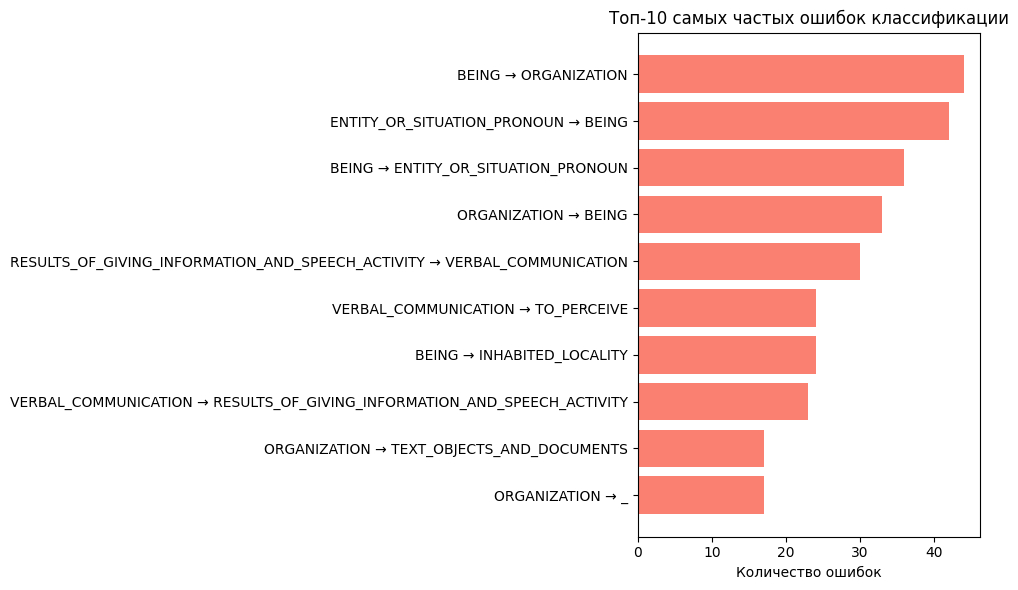

In [ ]:
# визуализирую топ-10 самых популярных ошибок
import matplotlib.pyplot as plt
top_errors = error_counts.most_common(10)
labels = [f"{true} → {pred}" for (true, pred), _ in top_errors]
values = [count for _, count in top_errors]
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='salmon')
plt.xlabel('Количество ошибок')
plt.title('Топ-10 самых частых ошибок классификации')
plt.gca().invert_yaxis()  # самая первая ошибка будет сверху
plt.tight_layout()
plt.show()

In [ ]:
# проверю на синтетических данных
def predict(sentence, tokenizer, model, device='cuda'): #(скопировала код из тетрадки)
    model.to(device)
    model.eval()  # переводим модель в режим оценки

    # Токенизация предложения
    tokens = tokenizer(
        sentence.split(),  # Разделяю предложение на слова
        is_split_into_words=True,  # Указываю, что вход уже разделен на слова
        return_tensors="pt",  # Возвращаю тензоры PyTorch
        truncation=True,  # Обрезаю предложение, если оно длиннее максимальной длины
        padding=True,  # Добавляю паддинг, если предложение короче максимальной длины
    )

    #  индексы слов для каждого токена
    word_ids = tokens.word_ids()

    # входные данные на устройство
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # предсказание
    with torch.no_grad():
        outputs = model(**tokens)  # Прямой проход через модель
        logits = outputs[1] if isinstance(outputs, tuple) else outputs  #  logits
        predictions = logits.argmax(dim=-1).squeeze().tolist()  # logits в предсказания

    # Сопоставляю предсказания с исходными словами
    aligned_predictions = []
    current_word_id = None

    for word_id, prediction in zip(word_ids, predictions):
        if word_id is not None and word_id != current_word_id:  # начало нового слова
            aligned_predictions.append(idx2sem[prediction])  #  ID в метку
            current_word_id = word_id

    # Соединяю слова и их предсказанные метки
    result = list(zip(sentence.split(), aligned_predictions))
    return result

In [ ]:
# синтетические данные
test_sentences = [
    "Окончил в 1966 году школу в Бронксе.",
    "Сергей Иванов работает в Google в Москве.",
    "Президент Франции Эммануэль Макрон посетил Берлин.",
    "Доктор Петрова из МГУ опубликовала новое исследование.",
    "Александр Пушкин родился в Москве в 1799 году.",
    "Компания Яндекс открыла новый офис в Казани.",
    "Мы летим в Нью-Йорк рейсом Аэрофлота SU-100.",
    "Профессор Смирнов и доцент Кузнецова участвовали в конференции в Санкт-Петербурге.",
    "Турнир по теннису Ролан Гаррос проходит в Париже.",
    "Директор Microsoft Сатья Наделла выступил на форуме в Сиэтле.",
    "Вчера видел Илон Маска в кафе Starbucks на Тверской.",
    "Картину Ван Гога купил музей Эрмитаж за 10 миллионов долларов."
]

print("="*50)
print("ТЕСТИРОВАНИЕ МОДЕЛИ NER")
print("="*50)

for sent in test_sentences:
    print("\nПредложение:", sent)
    predictions = predict(sent, tokenizer, model)
    print("Результаты:")
    for word, label in predictions:
        print(f"{word}: {label}")
    print("-"*50)

ТЕСТИРОВАНИЕ МОДЕЛИ NER

Предложение: Окончил в 1966 году школу в Бронксе.
Результаты:
Окончил: TO_LEARN_AND_RESEARCH
в: PREPOSITION
1966: CH_REFERENCE_AND_QUANTIFICATION
году: TIME
школу: ORGANIZATION
в: PREPOSITION
Бронксе.: INHABITED_LOCALITY
--------------------------------------------------

Предложение: Сергей Иванов работает в Google в Москве.
Результаты:
Сергей: BEING
Иванов: BEING
работает: TO_WORK
в: PREPOSITION
Google: ORGANIZATION
в: PREPOSITION
Москве.: INHABITED_LOCALITY
--------------------------------------------------

Предложение: Президент Франции Эммануэль Макрон посетил Берлин.
Результаты:
Президент: BEING
Франции: COUNTRY_AS_ADMINISTRATIVE_UNIT
Эммануэль: BEING
Макрон: BEING
посетил: MOTION
Берлин.: INHABITED_LOCALITY
--------------------------------------------------

Предложение: Доктор Петрова из МГУ опубликовала новое исследование.
Результаты:
Доктор: BEING
Петрова: BEING
из: PREPOSITION
МГУ: ORGANIZATION
опубликовала: TO_MAKE
новое: CH_REFERENCE_AND_QUANTIFIC

**замена self.encoder в моей бейзлайновой архитектуре (продолжу, если это правильно)**

In [ ]:
semantics_model = torch.load("/content/semantic_model_weights_1.pt") # итак я выгрузила эмбеддинги

In [ ]:
import random
import os
# Фиксирую seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# для обеспечения детерминизма в операциях на GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# вот тут вопрос: я опять беру свой датасет? я здесь запуталась
# то есть модель для NER теперь использует эмбеддинги, заточенные под семантику, мне же для проведения эксперимента нужно взять мой датасет?
filepath = pd.read_csv('/content/semclasses.csv')
filepath.head(5)

,form,semclass,NER
0,Детство,TIME,O
1,провёл,TO_SPEND_TIME,O
2,в,PREPOSITION,O
3,Надьсомбате,INHABITED_LOCALITY,B-LOC
4,с,PREPOSITION,O


In [ ]:
def parse_dataset(filepath): # (копия из моего семинара NER)
    sentences, all_labels = [], []
    df = pd.read_csv(filepath)

    current_sentence, current_labels = [], []

    for _, row in df.iterrows():
        form = str(row['form']) if pd.notna(row['form']) else ''
        ner_label = str(row['NER']) if pd.notna(row['NER']) else 'O'
        if form in {'.'}:
            if current_sentence:
                sentences.append(current_sentence)
                all_labels.append(current_labels)
                current_sentence, current_labels = [], []
        else:
            current_sentence.append(form)
            current_labels.append(ner_label)
    if current_sentence:
        sentences.append(current_sentence)
        all_labels.append(current_labels)

    return sentences, all_labels
sentences, labels = parse_dataset('/content/semclasses.csv')

In [ ]:
# Проверю
print(f"Количество предложений: {len(sentences)}")
print(f"Пример предложения: {sentences[0]}")
print(f"Пример меток: {labels[0]}")

Количество предложений: 3271
Пример предложения: ['Детство', 'провёл', 'в', 'Надьсомбате', 'с', '1860', 'г']
Пример меток: ['O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']


In [ ]:
# Разделю данные на тренировочные и валидационные (дальше идет просто копия из семинара)
from sklearn.model_selection import train_test_split
# Первое разделение: тренировачные данные 70% + остальное - 30%
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences, labels, test_size=0.3, random_state=42
)
# Второе разделение: валидационные - 20% и тестовые - 10%, всего temp = 30, test_size=0.333, т.к 10/30
val_sentences, test_sentences, val_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.333, random_state=42
)

In [ ]:
# определю теги и их ID
labels = {'I-ORG': 1,
            'B-LOC': 2,
            'B-ORG': 3,
            'I-LOC': 4,
            'I-PER': 5,
            'O': 6,
            'B-PER': 7}
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

In [ ]:
labels

{'I-ORG': 1,
 'B-LOC': 2,
 'B-ORG': 3,
 'I-LOC': 4,
 'I-PER': 5,
 'O': 6,
 'B-PER': 7}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
# класс NERDataset для обработки данных(копия из семинара NER):
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, label2id, max_length=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.label2id = label2id # cловарь для преобразования меток в числовые ID
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.sentences[idx]
        tags = self.labels[idx]

        # здесь происходит токенизация
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            padding='max_length',
            truncation=True, # обрезает последовательность, если она длиннее max_length
            max_length=self.max_length,
            return_offsets_mapping=True
        )

        # связываю метоки с токенами
        labels = []
        word_ids = encoding.word_ids()
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:  # специальные токены или паддинг
                labels.append(-100)
            elif word_id != previous_word_id:  # начало нового слова
                labels.append(self.label2id.get(tags[word_id], -100))
            else:  # подтокены
                labels.append(-100)
            previous_word_id = word_id

        encoding["labels"] = labels
        encoding.pop("offset_mapping")  # Удаляю offset_mapping, так как он не нужен

        return {key: torch.tensor(val) for key, val in encoding.items()} #  возвращает словарь с ключами: input_ids, attention_mask, labels


In [ ]:
def create_dataloader(sentences, labels, tokenizer, label2id, batch_size=64, max_length=128, shuffle=True):
    dataset = NERDataset(sentences, labels, tokenizer, label2id, max_length=max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
train_dataloader = create_dataloader(train_sentences, train_labels, tokenizer, label2id, shuffle=True)
val_dataloader = create_dataloader(val_sentences, val_labels, tokenizer, label2id, shuffle=True)
test_dataloader = create_dataloader(test_sentences, test_labels, tokenizer, label2id, shuffle=False)

In [ ]:
train_dataset = NERDataset(train_sentences, train_labels, tokenizer, label2id)
val_dataset = NERDataset(val_sentences, val_labels, tokenizer, label2id)
test_dataset = NERDataset(test_sentences, test_labels, tokenizer, label2id)

In [ ]:
from torch.optim import AdamW

In [ ]:
semantics_model = torch.load("semantic_model_weights_1.pt") # забыла, что уже выгружала, ладно пусть будет

**Замороженные веса encoder**

In [ ]:
class NERModelWithSemanticEncoder(nn.Module): # (по сути это архитектура из тетрадки NER, я просто поменяла название класса, чтобы не путаться)
    def __init__(self, num_classes, semantic_encoder):
        super().__init__()

        # передала семантический энкодер
        #  энкодер у меня обучен на задаче предсказания семантических классов
        self.bert = semantic_encoder

        # архитектура у меня сохраняется как из тетрадки NER
        self.num_labels = num_classes # NER
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 768),
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(768, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

        # замораживаю энкодер, его веса не обновляются
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        with torch.no_grad(): # отключение градиентов
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
        # предсказывает NER-метки
        sequence_output = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(sequence_output)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
            return loss, logits

        return logits

In [ ]:
# блин, я только потом поняла, что мне нужно, наверное, в init было добавить freeze_encoder=True

In [ ]:
semantic_model = SemanticClassModel(num_sem_classes=len(sem2idx)) # моя модель, которая обучалась только на семклассах
semantic_model.load_state_dict(torch.load("semantic_model_weights_1.pt")) # энкодер (semantic_model.bert) извлекается и передается в мою модель выше (NERModelWithSemanticEncoder)

<All keys matched successfully>

In [ ]:
semantic_encoder = semantic_model.bert # извлекаю BERT-энкодер из предварительно обученной модел и сохраняю его в переменную semantic_encoder

In [ ]:
model = NERModelWithSemanticEncoder(
    num_classes=len(labels),
    semantic_encoder=semantic_encoder # вот сюда передаю дообученный энкодер
)
model.to(device)

NERModelWithSemanticEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [ ]:
# Проверка на размерность и на заморозку
print("Размерность выхода энкодера:", model.bert.config.hidden_size)
for name, param in model.named_parameters():
    if 'bert' in name:
        print(name, param.requires_grad)

Размерность выхода энкодера: 768
bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias Fals

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
# (дальше стандартно - копия из семинара)
def compute_metrics(p):
    predictions, labels = p

    # Преобразование логитов в предсказанные классы
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for prediction, label_seq in zip(predictions, labels):
        current_predictions = []
        current_labels = []

        for pred, lab in zip(prediction, label_seq):
            if lab != -100:
                current_predictions.append(id2label[pred])
                current_labels.append(id2label[lab])

        if current_predictions:
            true_predictions.append(current_predictions)
            true_labels.append(current_labels)

    if not true_predictions:
        return {"precision": 0, "recall": 0, "f1": 0, "accuracy": 0}

    # Вычисление метрик
    precision = precision_score(true_labels, true_predictions, zero_division=0)
    recall = recall_score(true_labels, true_predictions, zero_division=0)
    f1 = f1_score(true_labels, true_predictions, zero_division=0)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }


In [ ]:
optimizer = AdamW(
    model.classifier.parameters(),
    lr=1e-3, # другой lr
    amsgrad=True)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=20,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1")

In [ ]:
from transformers import get_linear_schedule_with_warmup
total_steps = len(train_dataloader) * training_args.num_train_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    optimizers=(optimizer, scheduler),
    train_dataset=train_dataloader.dataset,
    eval_dataset=val_dataloader.dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

<ipython-input-79-13679824d179>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.216700,0.173096,0.548422,0.572727,0.560311,0.946962
2,0.191200,0.147461,0.545455,0.620455,0.580542,0.950825
3,0.150900,0.128430,0.623204,0.640909,0.631933,0.959356
4,0.145800,0.133752,0.668555,0.804545,0.730273,0.956137
5,0.138600,0.118504,0.651256,0.736364,0.691200,0.963380
6,0.133500,0.111184,0.742179,0.781818,0.761483,0.969175
7,0.138700,0.111909,0.680336,0.735227,0.706718,0.964507
8,0.134300,0.106606,0.749465,0.795455,0.771775,0.968612
9,0.127500,0.104763,0.733198,0.818182,0.773362,0.969738
10,0.136900,0.104413,0.722555,0.822727,0.769394,0.968853


TrainOutput(global_step=720, training_loss=0.13255842104554177, metrics={'train_runtime': 541.8584, 'train_samples_per_second': 84.487, 'train_steps_per_second': 1.329, 'total_flos': 0.0, 'train_loss': 0.13255842104554177, 'epoch': 20.0})

In [ ]:
# посмотрю метрики на валидационной части
val_metrics = trainer.evaluate(eval_dataset=val_dataset)

In [ ]:
metrics_data = [
    ["Loss", val_metrics['eval_loss'], f"{val_metrics['eval_loss']:.4f}"],
    ["Precision", val_metrics['eval_precision'], f"{val_metrics['eval_precision']*100:.1f}%"],
    ["Recall", val_metrics['eval_recall'], f"{val_metrics['eval_recall']*100:.1f}%"],
    ["F1", val_metrics['eval_f1'], f"{val_metrics['eval_f1']*100:.1f}%"],
    ["Accuracy", val_metrics['eval_accuracy'], f"{val_metrics['eval_accuracy']*100:.1f}%"]
]

print("\n" + tabulate(metrics_data,
                    headers=["Metric", "Value", "Percentage"],
                    tablefmt="grid",
                    floatfmt=".4f"))


+-----------+---------+--------------+
| Metric    |   Value | Percentage   |
+===========+=========+==============+
| Loss      |  0.0937 | 0.0937       |
+-----------+---------+--------------+
| Precision |  0.7734 | 77.3%        |
+-----------+---------+--------------+
| Recall    |  0.8261 | 82.6%        |
+-----------+---------+--------------+
| F1        |  0.7989 | 79.9%        |
+-----------+---------+--------------+
| Accuracy  |  0.9737 | 97.4%        |
+-----------+---------+--------------+


In [ ]:
def predict(sentence, tokenizer, model, device='cuda'): #(скопировала код из тетрадки)
    model.to(device)
    model.eval()  # переводим модель в режим оценки

    # Токенизация предложения
    tokens = tokenizer(
        sentence.split(),  # Разделяю предложение на слова
        is_split_into_words=True,  # Указываю, что вход уже разделен на слова
        return_tensors="pt",  # Возвращаю тензоры PyTorch
        truncation=True,  # Обрезаю предложение, если оно длиннее максимальной длины
        padding=True,  # Добавляю паддинг, если предложение короче максимальной длины
    )

    #  индексы слов для каждого токена
    word_ids = tokens.word_ids()

    # входные данные на устройство
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # предсказание
    with torch.no_grad():
        outputs = model(**tokens)  # Прямой проход через модель
        logits = outputs[1] if isinstance(outputs, tuple) else outputs  #  logits
        predictions = logits.argmax(dim=-1).squeeze().tolist()  # logits в предсказания

    # Сопоставляю предсказания с исходными словами
    aligned_predictions = []
    current_word_id = None

    for word_id, prediction in zip(word_ids, predictions):
        if word_id is not None and word_id != current_word_id:  # начало нового слова
            aligned_predictions.append(id2label[prediction])  #  ID в метку
            current_word_id = word_id

    # Соединяю слова и их предсказанные метки
    result = list(zip(sentence.split(), aligned_predictions))
    return result

In [ ]:
# Проверка на различных примерах
test_sentences = [
    "Окончил в 1966 году школу в Бронксе.",
    "Сергей Иванов работает в Google в Москве.",
    "Президент Франции Эммануэль Макрон посетил Берлин.",
    "Доктор Петрова из МГУ опубликовала новое исследование.",
    "Александр Пушкин родился в Москве в 1799 году.",
    "Компания Яндекс открыла новый офис в Казани.",
    "Мы летим в Нью-Йорк рейсом Аэрофлота SU-100.",
    "Профессор Смирнов и доцент Кузнецова участвовали в конференции в Санкт-Петербурге.",
    "Турнир по теннису Ролан Гаррос проходит в Париже.",
    "Директор Microsoft Сатья Наделла выступил на форуме в Сиэтле.",
    "Вчера видел Илон Маска в кафе Starbucks на Тверской.",
    "Картину Ван Гога купил музей Эрмитаж за 10 миллионов долларов."
]

print("="*50)
print("ТЕСТИРОВАНИЕ МОДЕЛИ NER")
print("="*50)

for sent in test_sentences:
    print("\nПредложение:", sent)
    predictions = predict(sent, tokenizer, model)
    print("Результаты:")
    for word, label in predictions:
        print(f"{word}: {label}")
    print("-"*50)

ТЕСТИРОВАНИЕ МОДЕЛИ NER

Предложение: Окончил в 1966 году школу в Бронксе.
Результаты:
Окончил: O
в: O
1966: O
году: O
школу: O
в: O
Бронксе.: B-LOC
--------------------------------------------------

Предложение: Сергей Иванов работает в Google в Москве.
Результаты:
Сергей: B-PER
Иванов: I-PER
работает: O
в: O
Google: B-ORG
в: O
Москве.: B-LOC
--------------------------------------------------

Предложение: Президент Франции Эммануэль Макрон посетил Берлин.
Результаты:
Президент: O
Франции: B-LOC
Эммануэль: B-PER
Макрон: I-PER
посетил: O
Берлин.: B-LOC
--------------------------------------------------

Предложение: Доктор Петрова из МГУ опубликовала новое исследование.
Результаты:
Доктор: O
Петрова: B-PER
из: O
МГУ: O
опубликовала: O
новое: O
исследование.: O
--------------------------------------------------

Предложение: Александр Пушкин родился в Москве в 1799 году.
Результаты:
Александр: B-PER
Пушкин: I-PER
родился: O
в: O
Москве: B-LOC
в: O
1799: O
году.: O
---------------------

In [ ]:
from tabulate import tabulate
from termcolor import colored

def get_colored_label(label):
    colors = {
        'B-PER': 'green',
        'I-PER': 'green',
        'B-LOC': 'blue',
        'I-LOC': 'blue',
        'B-ORG': 'magenta',
        'I-ORG': 'magenta',
        'O': 'white'
    }
    return colored(label, colors.get(label, 'white'))

print("="*70)
print(colored(" ТЕСТИРОВАНИЕ МОДЕЛИ NER ".center(70), 'white', 'on_blue'))
print("="*70)

for sent in test_sentences:
    # Получаем предсказания
    predictions = predict(sent, tokenizer, model)


    table_data = []
    current_entity = None
    entity_words = []

    for word, label in predictions:
        if label in ['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'O']:
            if label.startswith('B-'):
                if current_entity:
                    table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
                current_entity = label
                entity_words = [word]
            elif label.startswith('I-') and current_entity and current_entity == label.replace('I-', 'B-'):
                entity_words.append(word)
            elif label == 'O':
                if current_entity:
                    table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
                current_entity = None
                entity_words = []
                table_data.append([word, "O", get_colored_label("O")])

    # Добавляем последнюю сущность, если осталась
    if current_entity:
        table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
    print("\n" + colored(f" Предложение: ", 'yellow') + colored(sent, 'cyan'))
    print(tabulate(table_data,
                 headers=[colored("Токен", 'yellow'),
                         colored("Тип сущности", 'yellow'),
                         colored("Метка", 'yellow')],
                 tablefmt="fancy_grid",
                 colalign=("left", "center", "center")))
    print("-"*70)

                       ТЕСТИРОВАНИЕ МОДЕЛИ NER                        

 Предложение: Окончил в 1966 году школу в Бронксе.
╒══════════╤════════════════╤═════════╕
│ Токен    │  Тип сущности  │  Метка  │
╞══════════╪════════════════╪═════════╡
│ Окончил  │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ в        │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ 1966     │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ году     │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ школу    │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ в        │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ Бронксе. │      LOC       │  B-LOC  │
╘══════════╧════════════════╧═════════╛
----------------------------------------------------------------------

 Предложение: Сергей Иванов работает в Google в Москве.
╒═══════════════╤════════════════╤═════════╕
│ Токен         │  Тип с

In [ ]:
# Получение предсказаний на тестовых данных
test_predictions = trainer.predict(test_dataset)

In [ ]:
import numpy as np

# Логиты и метки
logits = test_predictions.predictions
true_labels = test_predictions.label_ids

# Преобразование логитов в предсказанные классы
predicted_labels = np.argmax(logits, axis=2)
# Фильтрация специальных токенов (где true_labels != -100)
filtered_preds = []
filtered_true = []

for pred_seq, true_seq in zip(predicted_labels, true_labels):
    for pred, true in zip(pred_seq, true_seq):
        if true != -100:  # игнор паддинг и спец. токены
            filtered_preds.append(id2label[pred])
            filtered_true.append(id2label[true])

In [ ]:
from seqeval.metrics import classification_report

print(classification_report([filtered_true], [filtered_preds], zero_division=0))

              precision    recall  f1-score   support

         LOC       0.74      0.92      0.82       218
         ORG       0.80      0.51      0.62        73
         PER       0.81      0.84      0.83       132

   micro avg       0.76      0.82      0.79       423
   macro avg       0.78      0.76      0.75       423
weighted avg       0.77      0.82      0.79       423



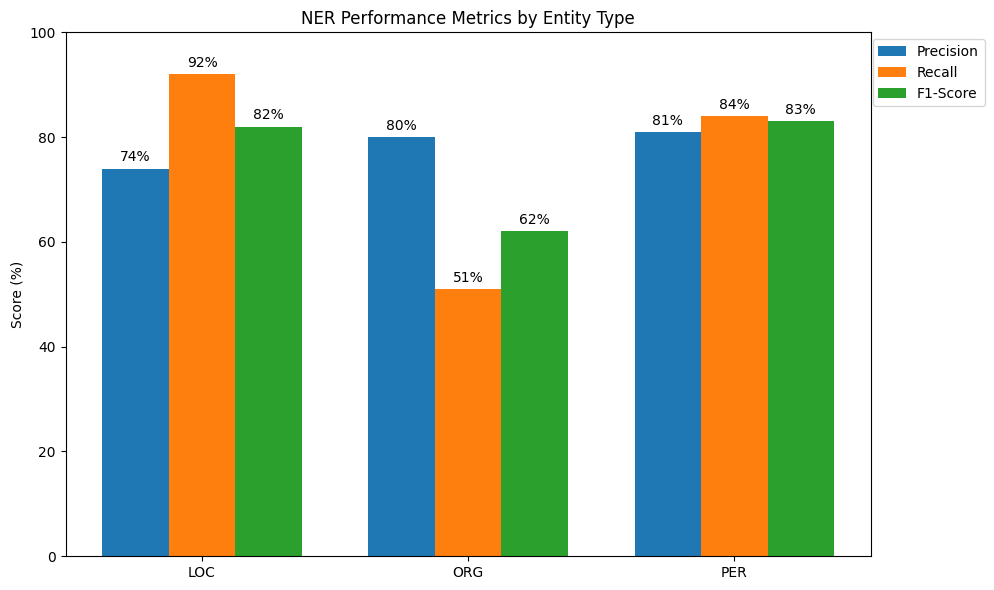

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['LOC', 'ORG', 'PER']
metrics = ['Precision', 'Recall', 'F1-Score']
data = np.array([
    [74, 92, 82],  # LOC
    [80, 51, 62],  # ORG
    [81, 84, 83]   # PER
])

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, data[:, i], width, label=metric)

ax.set_ylabel('Score (%)')
ax.set_title('NER Performance Metrics by Entity Type')
ax.set_xticks(x + width)
ax.set_xticklabels(categories)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax.set_ylim(0, 100)

for i in range(len(categories)):
    for j in range(len(metrics)):
        height = data[i, j]
        ax.annotate(f'{height}%',
                    xy=(x[i] + j*width, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

NERModelWithSemanticEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

**размороженные веса encoder**

In [ ]:
import random
import os
# Фиксирую seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# для обеспечения детерминизма в операциях на GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
semantics_model = torch.load("semantic_model_weights_1.pt")

In [ ]:
class NERModelWithSemanticEncoder(nn.Module):
    def __init__(self, num_classes, semantic_encoder):
        super().__init__()

        self.bert = semantic_encoder
        self.num_labels = num_classes
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 768),
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(768, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

        # заморозка энкодера (первый слой будет заморожен, насколько я поняла, то разморозка должна быть постепенная, чтобы не сломать архитектуру)
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # градиенты будут вычисляться только для размороженных параметров
        with torch.set_grad_enabled(any(p.requires_grad for p in self.bert.parameters())):
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

        sequence_output = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(
                ignore_index=-100
            )
            loss = loss_fn(
                logits.view(-1, self.num_labels),
                labels.view(-1)
            )

        return (loss, logits) if loss is not None else logits

In [ ]:
semantic_model = SemanticClassModel(num_sem_classes=len(sem2idx)) # все тоже самое
semantic_model.load_state_dict(torch.load("semantic_model_weights_1.pt"))

<All keys matched successfully>

In [ ]:
semantic_encoder = semantic_model.bert

In [ ]:
model = NERModelWithSemanticEncoder(
    num_classes=len(labels),
    semantic_encoder=semantic_encoder
)
model.to(device)

NERModelWithSemanticEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(p):
    predictions, labels = p

    # Преобразование логитов в предсказанные классы
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for prediction, label_seq in zip(predictions, labels):
        current_predictions = []
        current_labels = []

        for pred, lab in zip(prediction, label_seq):
            if lab != -100:
                current_predictions.append(id2label[pred])
                current_labels.append(id2label[lab])

        if current_predictions:
            true_predictions.append(current_predictions)
            true_labels.append(current_labels)

    if not true_predictions:
        return {"precision": 0, "recall": 0, "f1": 0, "accuracy": 0}

    # Вычисление метрик
    precision = precision_score(true_labels, true_predictions, zero_division=0)
    recall = recall_score(true_labels, true_predictions, zero_division=0)
    f1 = f1_score(true_labels, true_predictions, zero_division=0)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }


In [ ]:
encoder_lr = 1e-5  # lr для энкодера
classifier_lr = 1e-3  # lr для головы
# вот тут важно, мне советовали брать отдельныц lr Для энкодера и для classifier
optimizer = AdamW([
    {'params': model.classifier.parameters(), 'lr': classifier_lr},
    {'params': model.bert.parameters(), 'lr': encoder_lr}
], amsgrad=True)

In [ ]:
from transformers import TrainerCallback, TrainerState, TrainerControl
# а также добавить нужно постепенную разморозку (но это все копия из моего NER)
class UnfreezeCallback(TrainerCallback):
    def __init__(self, encoder, unfreeze_epoch=2, layers_per_epoch=1):
        self.encoder = encoder
        self.unfreeze_epoch = unfreeze_epoch
        self.encoder_lr = encoder_lr
        self.layers_per_epoch = layers_per_epoch
        self.frozen_layers = [layer for layer in reversed(encoder.encoder.layer)] # Исправила: теперь слои BERT должны размораживаться от 12 к 1
        # self.frozen_layers = [layer for layer in encoder.encoder.layer]  Было: все слои BERT размораживались от 1 к 12
        self.current_unfrozen = 0

    def on_epoch_begin(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if state.epoch >= self.unfreeze_epoch and self.current_unfrozen < len(self.frozen_layers):
            # разморозка слоев
            for layer in self.frozen_layers[self.current_unfrozen : self.current_unfrozen + self.layers_per_epoch]:
                for param in layer.parameters():
                    param.requires_grad = True

            self.current_unfrozen += self.layers_per_epoch
            #print(f"Unfrozen {self.current_unfrozen} BERT layers at epoch {int(state.epoch)+1}")

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=20,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1")

In [ ]:
from transformers import get_linear_schedule_with_warmup
total_steps = len(train_dataloader) * training_args.num_train_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    optimizers=(optimizer, scheduler),
    train_dataset=train_dataloader.dataset,
    eval_dataset=val_dataloader.dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=5),
        UnfreezeCallback(
            encoder=model.bert,  # передаю сам энкодер, его слои будут постепенно размораживаться
            unfreeze_epoch=2, layers_per_epoch=1)
    ]
)
# unfreeze_epoch=2 - это номер эпохи, с которой начинается разморозка
# layers_per_epoch=1 - rоличество слоёв, которые размораживаются за одну эпоху

<ipython-input-103-2ac4820acdac>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Обучение модели
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.216700,0.173096,0.548422,0.572727,0.560311,0.946962
2,0.191200,0.147461,0.545455,0.620455,0.580542,0.950825
3,0.149200,0.125367,0.634093,0.663636,0.648529,0.961690
4,0.134800,0.118595,0.702488,0.802273,0.749072,0.965795
5,0.119000,0.102588,0.727181,0.814773,0.768489,0.969738
6,0.107500,0.092332,0.774648,0.812500,0.793123,0.974004
7,0.102700,0.083373,0.814238,0.831818,0.822934,0.977304
8,0.097900,0.080056,0.799154,0.859091,0.828039,0.977706
9,0.083400,0.077109,0.790890,0.868182,0.827736,0.977465
10,0.076400,0.074407,0.797311,0.876136,0.834867,0.978672


TrainOutput(global_step=576, training_loss=0.10289034154266119, metrics={'train_runtime': 1311.6444, 'train_samples_per_second': 34.903, 'train_steps_per_second': 0.549, 'total_flos': 0.0, 'train_loss': 0.10289034154266119, 'epoch': 16.0})

In [ ]:
# посмотрю метрики на валидационной части
val_metrics = trainer.evaluate(eval_dataset=val_dataset)

In [ ]:
metrics_data = [
    ["Loss", val_metrics['eval_loss'], f"{val_metrics['eval_loss']:.4f}"],
    ["Precision", val_metrics['eval_precision'], f"{val_metrics['eval_precision']*100:.1f}%"],
    ["Recall", val_metrics['eval_recall'], f"{val_metrics['eval_recall']*100:.1f}%"],
    ["F1", val_metrics['eval_f1'], f"{val_metrics['eval_f1']*100:.1f}%"],
    ["Accuracy", val_metrics['eval_accuracy'], f"{val_metrics['eval_accuracy']*100:.1f}%"]
]

print("\n" + tabulate(metrics_data,
                    headers=["Metric", "Value", "Percentage"],
                    tablefmt="grid",
                    floatfmt=".4f"))


+-----------+---------+--------------+
| Metric    |   Value | Percentage   |
+===========+=========+==============+
| Loss      |  0.0695 | 0.0695       |
+-----------+---------+--------------+
| Precision |  0.8296 | 83.0%        |
+-----------+---------+--------------+
| Recall    |  0.8739 | 87.4%        |
+-----------+---------+--------------+
| F1        |  0.8511 | 85.1%        |
+-----------+---------+--------------+
| Accuracy  |  0.9811 | 98.1%        |
+-----------+---------+--------------+


In [ ]:
def predict(sentence, tokenizer, model, device='cuda'): #(скопировала код из тетрадки)
    model.to(device)
    model.eval()  # переводим модель в режим оценки

    # Токенизация предложения
    tokens = tokenizer(
        sentence.split(),  # Разделяю предложение на слова
        is_split_into_words=True,  # Указываю, что вход уже разделен на слова
        return_tensors="pt",  # Возвращаю тензоры PyTorch
        truncation=True,  # Обрезаю предложение, если оно длиннее максимальной длины
        padding=True,  # Добавляю паддинг, если предложение короче максимальной длины
    )

    #  индексы слов для каждого токена
    word_ids = tokens.word_ids()

    # входные данные на устройство
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # предсказание
    with torch.no_grad():
        outputs = model(**tokens)  # Прямой проход через модель
        logits = outputs[1] if isinstance(outputs, tuple) else outputs  #  logits
        predictions = logits.argmax(dim=-1).squeeze().tolist()  # logits в предсказания

    # Сопоставляю предсказания с исходными словами
    aligned_predictions = []
    current_word_id = None

    for word_id, prediction in zip(word_ids, predictions):
        if word_id is not None and word_id != current_word_id:  # начало нового слова
            aligned_predictions.append(id2label[prediction])  #  ID в метку
            current_word_id = word_id

    # Соединяю слова и их предсказанные метки
    result = list(zip(sentence.split(), aligned_predictions))
    return result

In [ ]:
# Проверка на различных примерах
test_sentences = [
    "Окончил в 1966 году школу в Бронксе.",
    "Сергей Иванов работает в Google в Москве.",
    "Президент Франции Эммануэль Макрон посетил Берлин.",
    "Доктор Петрова из МГУ опубликовала новое исследование.",
    "Александр Пушкин родился в Москве в 1799 году.",
    "Компания Яндекс открыла новый офис в Казани.",
    "Мы летим в Нью-Йорк рейсом Аэрофлота SU-100.",
    "Профессор Смирнов и доцент Кузнецова участвовали в конференции в Санкт-Петербурге.",
    "Турнир по теннису Ролан Гаррос проходит в Париже.",
    "Директор Microsoft Сатья Наделла выступил на форуме в Сиэтле.",
    "Вчера видел Илон Маска в кафе Starbucks на Тверской.",
    "Картину Ван Гога купил музей Эрмитаж за 10 миллионов долларов."
]

print("="*50)
print("ТЕСТИРОВАНИЕ МОДЕЛИ NER")
print("="*50)

for sent in test_sentences:
    print("\nПредложение:", sent)
    predictions = predict(sent, tokenizer, model)
    print("Результаты:")
    for word, label in predictions:
        print(f"{word}: {label}")
    print("-"*50)

ТЕСТИРОВАНИЕ МОДЕЛИ NER

Предложение: Окончил в 1966 году школу в Бронксе.
Результаты:
Окончил: O
в: O
1966: O
году: O
школу: O
в: O
Бронксе.: B-LOC
--------------------------------------------------

Предложение: Сергей Иванов работает в Google в Москве.
Результаты:
Сергей: B-PER
Иванов: I-PER
работает: O
в: O
Google: B-ORG
в: O
Москве.: B-LOC
--------------------------------------------------

Предложение: Президент Франции Эммануэль Макрон посетил Берлин.
Результаты:
Президент: O
Франции: B-LOC
Эммануэль: B-PER
Макрон: I-PER
посетил: O
Берлин.: B-LOC
--------------------------------------------------

Предложение: Доктор Петрова из МГУ опубликовала новое исследование.
Результаты:
Доктор: O
Петрова: I-PER
из: O
МГУ: B-ORG
опубликовала: O
новое: O
исследование.: O
--------------------------------------------------

Предложение: Александр Пушкин родился в Москве в 1799 году.
Результаты:
Александр: B-PER
Пушкин: I-PER
родился: O
в: O
Москве: B-LOC
в: O
1799: O
году.: O
-----------------

In [ ]:
from tabulate import tabulate
from termcolor import colored

def get_colored_label(label):
    colors = {
        'B-PER': 'green',
        'I-PER': 'green',
        'B-LOC': 'blue',
        'I-LOC': 'blue',
        'B-ORG': 'magenta',
        'I-ORG': 'magenta',
        'O': 'white'
    }
    return colored(label, colors.get(label, 'white'))

print("="*70)
print(colored(" ТЕСТИРОВАНИЕ МОДЕЛИ NER ".center(70), 'white', 'on_blue'))
print("="*70)

for sent in test_sentences:
    # Получаем предсказания
    predictions = predict(sent, tokenizer, model)


    table_data = []
    current_entity = None
    entity_words = []

    for word, label in predictions:
        if label in ['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'O']:
            if label.startswith('B-'):
                if current_entity:
                    table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
                current_entity = label
                entity_words = [word]
            elif label.startswith('I-') and current_entity and current_entity == label.replace('I-', 'B-'):
                entity_words.append(word)
            elif label == 'O':
                if current_entity:
                    table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
                current_entity = None
                entity_words = []
                table_data.append([word, "O", get_colored_label("O")])

    # Добавляем последнюю сущность, если осталась
    if current_entity:
        table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
    print("\n" + colored(f" Предложение: ", 'yellow') + colored(sent, 'cyan'))
    print(tabulate(table_data,
                 headers=[colored("Токен", 'yellow'),
                         colored("Тип сущности", 'yellow'),
                         colored("Метка", 'yellow')],
                 tablefmt="fancy_grid",
                 colalign=("left", "center", "center")))
    print("-"*70)

                       ТЕСТИРОВАНИЕ МОДЕЛИ NER                        

 Предложение: Окончил в 1966 году школу в Бронксе.
╒══════════╤════════════════╤═════════╕
│ Токен    │  Тип сущности  │  Метка  │
╞══════════╪════════════════╪═════════╡
│ Окончил  │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ в        │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ 1966     │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ году     │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ школу    │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ в        │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ Бронксе. │      LOC       │  B-LOC  │
╘══════════╧════════════════╧═════════╛
----------------------------------------------------------------------

 Предложение: Сергей Иванов работает в Google в Москве.
╒═══════════════╤════════════════╤═════════╕
│ Токен         │  Тип с

In [ ]:
# Получение предсказаний на тестовых данных
test_predictions = trainer.predict(test_dataset)

In [ ]:
import numpy as np
# (все копия)
# Логиты и метки
logits = test_predictions.predictions
true_labels = test_predictions.label_ids

# Преобразование логитов в предсказанные классы
predicted_labels = np.argmax(logits, axis=2)
# Фильтрация специальных токенов (где true_labels != -100)
filtered_preds = []
filtered_true = []

for pred_seq, true_seq in zip(predicted_labels, true_labels):
    for pred, true in zip(pred_seq, true_seq):
        if true != -100:  # игнор паддинг и спец. токены
            filtered_preds.append(id2label[pred])
            filtered_true.append(id2label[true])

In [ ]:
from seqeval.metrics import classification_report

print(classification_report([filtered_true], [filtered_preds], zero_division=0))

              precision    recall  f1-score   support

         LOC       0.85      0.94      0.89       218
         ORG       0.73      0.63      0.68        73
         PER       0.85      0.90      0.88       132

   micro avg       0.83      0.87      0.85       423
   macro avg       0.81      0.82      0.81       423
weighted avg       0.83      0.87      0.85       423



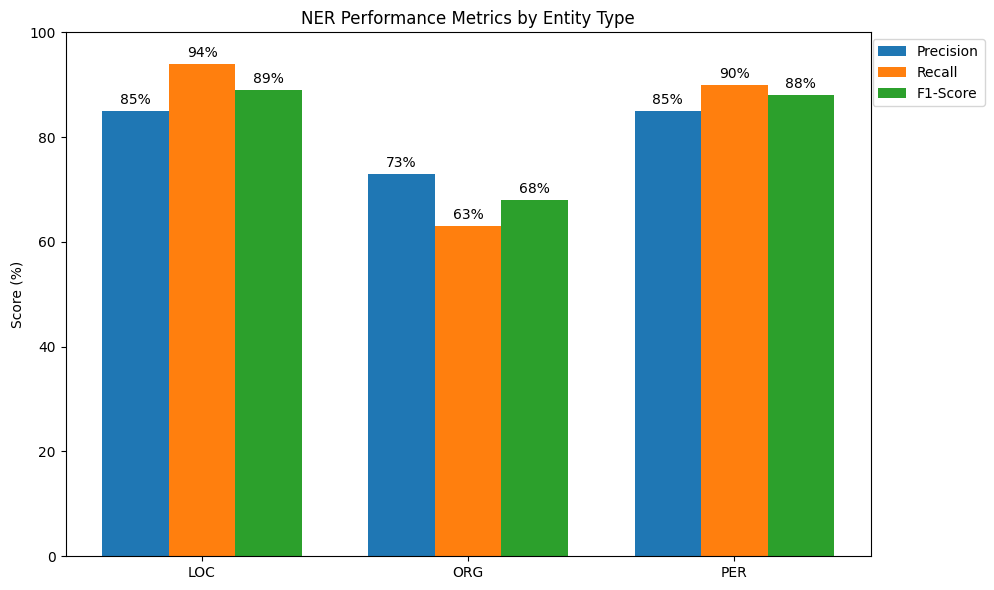

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['LOC', 'ORG', 'PER']
metrics = ['Precision', 'Recall', 'F1-Score']
data = np.array([
    [85, 94, 89],  # LOC
    [73, 63, 68],  # ORG
    [85, 90, 88]   # PER
])

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, data[:, i], width, label=metric)

ax.set_ylabel('Score (%)')
ax.set_title('NER Performance Metrics by Entity Type')
ax.set_xticks(x + width)
ax.set_xticklabels(categories)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax.set_ylim(0, 100)

for i in range(len(categories)):
    for j in range(len(metrics)):
        height = data[i, j]
        ax.annotate(f'{height}%',
                    xy=(x[i] + j*width, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

NERModelWithSemanticEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-